<a href="https://colab.research.google.com/github/hyunchul78/Android-AudioRecorder-App/blob/master/Home_Price_Prediction_peter_20190721_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Price Prediction Project
### Team member: 
Rahul Kulkarni, Vidhu Nath, Hyunchul (Peter) Kim, Shujing Dong

 # Baseline 
 # Overview
 ## 1. Introduction and problem statement
 
The Home Price Prediction Project [project](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) aims to predict home prices of residential homes in Ames, Iowa. The dataset includes 80 independent variables (features)  that capture various aspects of residential homes in Ames, Iowa.  These features will form the basis of our regression model to predict home sale prices.
 
From our preliminary analysis of the given dataset, we observed price value as the target variable,
37 numeric features (e.g., year build ) and 43 categorical features(e.g., fireplaces). Training and Test data show an equal split of sample sizes of 1460 and 1459 samples  respectively.

## 2. Initial findings from EDA
 
- Finding1: 
The top 6 features with missing values (>15%) are identical for train and test data, namely 'PoolQC',' MiscFeature',' Alley', 'Fence', 'FireplaceQu'.  All six features are in the categorical set. PoolQC has the most missing data,  likely due to the fact that most homes don't have a pool.  
Finding 1 lead us to believe that the 6 features do not provide enough information to the model.  Given this finding we will remove them from the training and test data.  

- Finding2: There are discrete numerical features and continous numerical features. We intend to normalize the discrete numerical features and explore various techniqes for normalization.  
For  example, features  that exihibit extreme skeweness, we will apply log transformation for normalization.

- Finding3: Log transformation performs well in normalizing sales price . 
- Finding4: Top 10 features that are highly correlated with SalePrice are: OverallQual', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea' and 'YearRemodAdd'. 
Out of the top ten features, GarageCars' and GarageArea', 'GrLivArea and TotRmsAbvGrd, TotalBsmtSF and 1stFlrSF are highly correlated, which shows multicolinearity. Given this finding we would transform or select features to avoid multicolinearity.
- Finding5: Top 5 features that are positively correlated with SalePrice are:OverallQual, YearBuilt, GrLivArea , GarageCars ,GarageArea.   
Top 5 features that are negatively correlated with SalePrice are: ExterQual, BstmQual, KitchenQual, GarageType, Garage Finish.

 
 
 ## 3. Assumptions: 
As we mainly use regression, the assumptions we make about the sample data are that the samples are normally distributed and there is no multicolinearity between features.


    
## 4. Approaches: 
The initial set of approaches we intend to undertake are listed below, based on the outcome of our analysis we may decide to pick the one(s) which are most optimal for our solution.

  1. Models: 
    - linear regression:   
      specifically LASSO Regression (sensitive to outliers), Kernal regression, decision tree regression. 
      We will mainly focus on linear regression, and try out different regressors. 
    - DNNs 
    - Random Forest  
      We also plan to try CNN and Random Forest to see how they perform for this prediction.
      
  2. Feature engineering: 
    - Feature selection: most influential features, features with multicolinearity, least infuential features
    - Missing data processing: fill the missing value with 0, mean, median, categorial with 'None'
    - Normalization Transformation: log operator and etc
    - Categorical feature transformation: encoding/ One hot encoding
 3. Metrics:
       Accuracy, F1 score

 
 ## 5. Issues we may encounter:
 Based on our initial analysis we anticipate that some of the challenges we may encounter to be around feature selection and feature engineering including normalization, selection of the most impactful features, selection and feature transformation to avoid multicolinearity, transformation of categorical features, and regularization to penalize overfitting. Additionally  doing ensemble and cross-validation to improve the model performance.




#Data overview 


In [0]:
##We use colab to run this notebook
##It assumes the input files are available in the following dirs under My Drive in gdrive
##Directory structure: Colab Notebooks/w207_final_project/house-prices-advanced-regression-techniques
##It also needs access to gdrive 
import pandas as pd
import numpy as np
import scipy.stats as stat
import time
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

import matplotlib as mp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive 
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Get data will load file from your gdrive. 

def get_data():
    #get train data
    train_data_path ='gdrive/My Drive/Colab Notebooks/w207_final_project/house-prices-advanced-regression-techniques/train.csv'
    train = pd.read_csv(train_data_path)
    
   
    #get test data
    test_data_path ='gdrive/My Drive/Colab Notebooks/w207_final_project/house-prices-advanced-regression-techniques/test.csv'
    test = pd.read_csv(test_data_path)
    return train , test

def get_combined_data():
    #reading train data
    train , test = get_data()

    target = train.SalePrice
    train.drop(['SalePrice'],axis = 1 , inplace = True)

    combined = train.append(test)
  
    combined.reset_index(inplace=True)  
    combined.drop(['index', 'Id'], inplace=True, axis=1)
    return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()
  
#Load train and test data into pandas DataFrames
train, test = get_data()
# original data frame backup for reference
train_orig = train.copy()
test_orig = test.copy()

In [0]:
# Quick look at the train data set.
combined.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [0]:
combined.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [0]:
# Feature overview

# Check how many numeric and categorical features exist
# SalePrice (Output) included
numeric_columns = [f for f in train.columns if train.dtypes[f] != 'object']
category_columns = [f for f in train.columns if train.dtypes[f] == 'object']
print('Numeric features: {}'.format(len(numeric_columns)))
print('Categorical features: {}'.format(len(category_columns)))
print("Train and Test datasets size:")
train.shape, test.shape

Numeric features: 38
Categorical features: 43
Train and Test datasets size:


((1460, 81), (1459, 80))

In [0]:
print('Numeric feature names : {}'.format(numeric_columns))
print('Categorical feature names : {}'.format(category_columns))


print('Categorical feature names : {}'.format(np.shape(category_columns)))

Numeric feature names : ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
Categorical feature names : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional'

Total of 2919 data sets: 1460 Train +  1459 Test set

#Exploratory Data Analysis

##1. Missing data

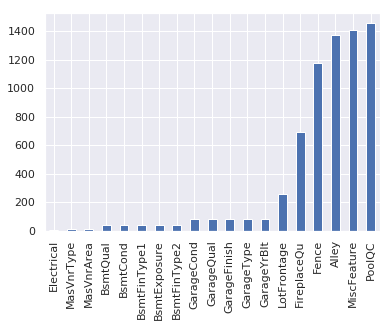

In [0]:
# Find the missing data from each category, and see what's up with that.\

missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

# Reconvert missing lists to have all features with missing data
missing_train = missing_train[missing_train > 0]
missing_test = missing_test[missing_test > 0]

# Sort from least to greatest
missing_train.sort_values(inplace=True)
missing_test.sort_values(inplace=True)


# Plot to see features with the most missing values in train data
missing_train.plot.bar()


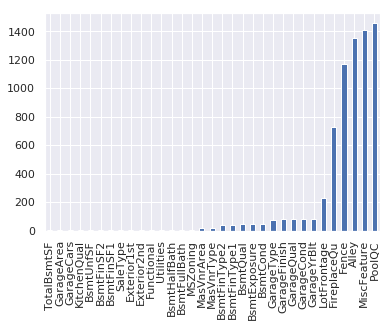

In [0]:
# Plot to see features with the most missing values in test data
missing_test.plot.bar()

In [0]:
def percent_missing(data):
  total =data.isnull().sum().sort_values(ascending=False)
  percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent of Missing values'])
  # find features with most missing values
  print(missing_data.head(10))
  
print('Features with most missing values in train data:')
percent_missing(train_data)
print('Features with most missing values in test data:')
percent_missing(test_data)


Features with most missing values in train data:
              Total Missing  Percent of Missing values
PoolQC                 1453                   0.995205
MiscFeature            1406                   0.963014
Alley                  1369                   0.937671
Fence                  1179                   0.807534
FireplaceQu             690                   0.472603
LotFrontage             259                   0.177397
GarageCond               81                   0.055479
GarageType               81                   0.055479
GarageYrBlt              81                   0.055479
GarageFinish             81                   0.055479
Features with most missing values in test data:
              Total Missing  Percent of Missing values
PoolQC                 1456                   0.997944
MiscFeature            1408                   0.965045
Alley                  1352                   0.926662
Fence                  1169                   0.801234
FireplaceQu            

###Finding1: the top 6 features with most missing values (>15%) are identical for train and test data, namely 'PoolQC','MiscFeature','Alley','Fence','FireplaceQu', all of them are categorical data. PoolQC has the most missing data - most likely due to the fact that most homes don't have a pool.  It indicates that the 6 features don't provide enough information to the prediction, so need to remove them from the training and test data.

In [0]:
# remove features that have more than 15% of missing values in train and test
train_new= train_data.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'] ,axis=1)
test_new= test_data.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'] ,axis=1)

# fill missing values in rest of the features in trainning data

category_columns_new =[f for f in train_new.columns if train_new.dtypes[f] == 'object']
train_numeric=train_new[numeric_columns].fillna(0)
train_category = train_new[category_columns_new].fillna('None')
train_new=pd.concat([train_category,train_numeric], axis=1, sort=False)
train_new.isnull().sum()

MSZoning         0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
                ..
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF 

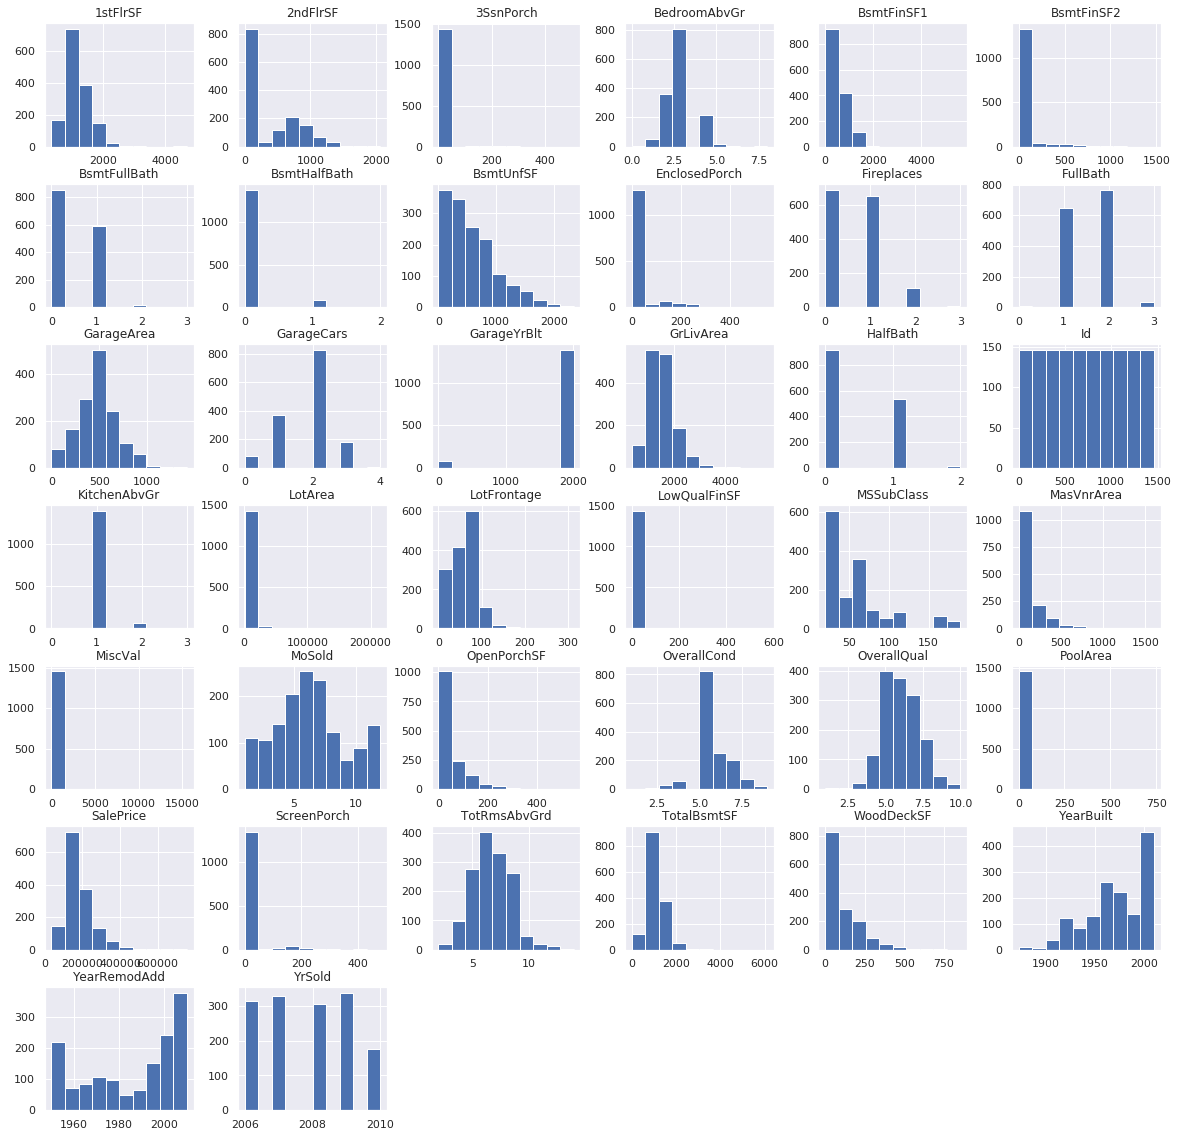

In [0]:
#show the histgram of numerical features
train_new.hist(figsize=(20,20))
plt.show()


###Finding2: There are discrete numerical features and continous numerical features, need to figure out how to normalize the discrete numerical features. Some features are extremely skcrewed, we need to take log transformation to normalize.

For categorical feature, we have transformed them in feature engineering part with one hot encoding. 

##2. Analysis of dependent variable: sales price

Skewness before log transformation:  1.88
Kurtosis before log transformation:  6.54


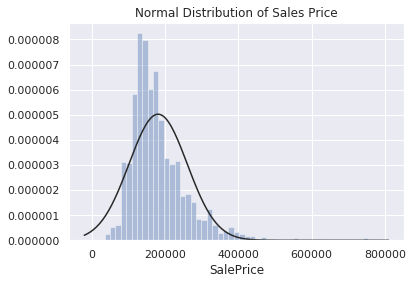

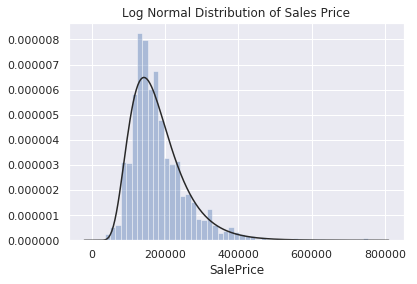

In [0]:
sales_price = train_new['SalePrice']

plt.figure(1); plt.title('Normal Distribution of Sales Price')
sns.distplot(sales_price, kde=False, fit=stat.norm)
plt.figure(2); plt.title('Log Normal Distribution of Sales Price')
sns.distplot(sales_price, kde=False, fit=stat.lognorm)

print("Skewness before log transformation: ", round(train_new['SalePrice'].skew(), 2))
print("Kurtosis before log transformation: ", round(train_new['SalePrice'].kurt(), 2))

# Looks Like log of the nomral would be the best distribution to test with

### Finding3: log transform performs well in normalizing sales price . 

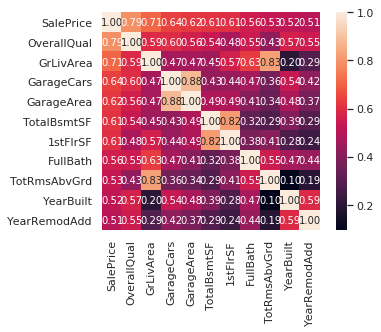

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64 

----------------------
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [0]:
#use heatmap to plot the correlation 
columns = train_new.corr().nlargest(11,'SalePrice')['SalePrice'].index
sns.heatmap(np.corrcoef(train_new[columns].values.T), cbar=True, annot=True, 
            square=True, fmt='.2f', annot_kws={'size': 10}, 
            yticklabels=columns.values, xticklabels=columns.values)
plt.show()

# Let us print top correlated features (both positively and negatively) with SalePrice
corr_matrix = train_new.corr()
print (corr_matrix['SalePrice'].sort_values(ascending=False)[:11], '\n') # top 10 values
print ('----------------------')
print (corr_matrix['SalePrice'].sort_values(ascending=False)[-10:]) # bottom 10 values

###Finding4: Top 10 features that are highly correlated with SalePrice  are: OverallQual','YearBuilt','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath', 'TotRmsAbvGrd', 'GarageCars','GarageArea' and 'YearRemodAdd'. Out of the top ten features, GarageCars' and GarageArea', 'GrLivArea and TotRmsAbvGrd, TotalBsmtSF and 1stFlrSF are highly correlated, which shows multicolinearity. We need to transform or select features to avoid multicolinearity. 

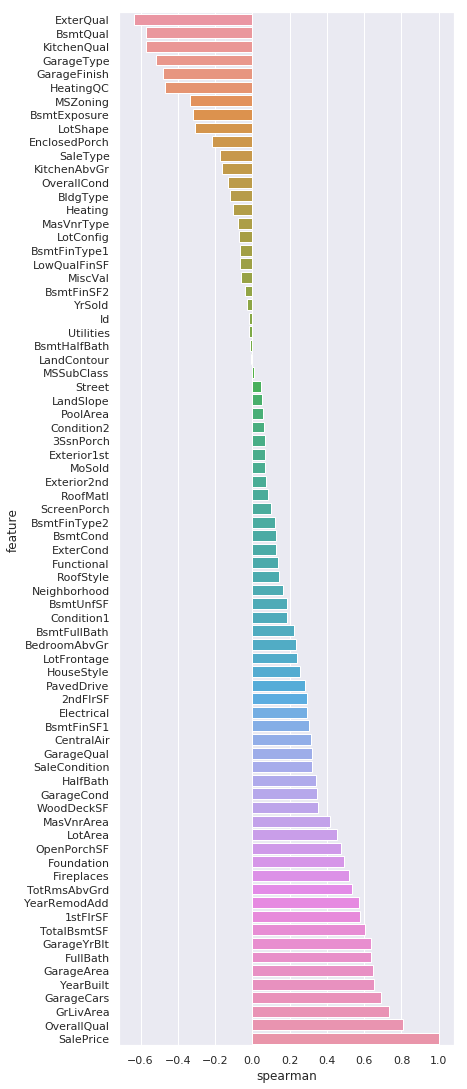

In [0]:
# plot correlations between variables again

def corr_diagrams(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    

features = train_new.columns
corr_diagrams(train_new, features)

### Finding5: Top 5 features that are positively correlated with SalePrice  are: OverallQual','YearBuilt,GrLivArea,GarageCars,GarageArea. Top 5 features that are negatively correlated with SalePrice  are: ExterQual, BstmQual,KitchenQual, GarageType, Garage Finish.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


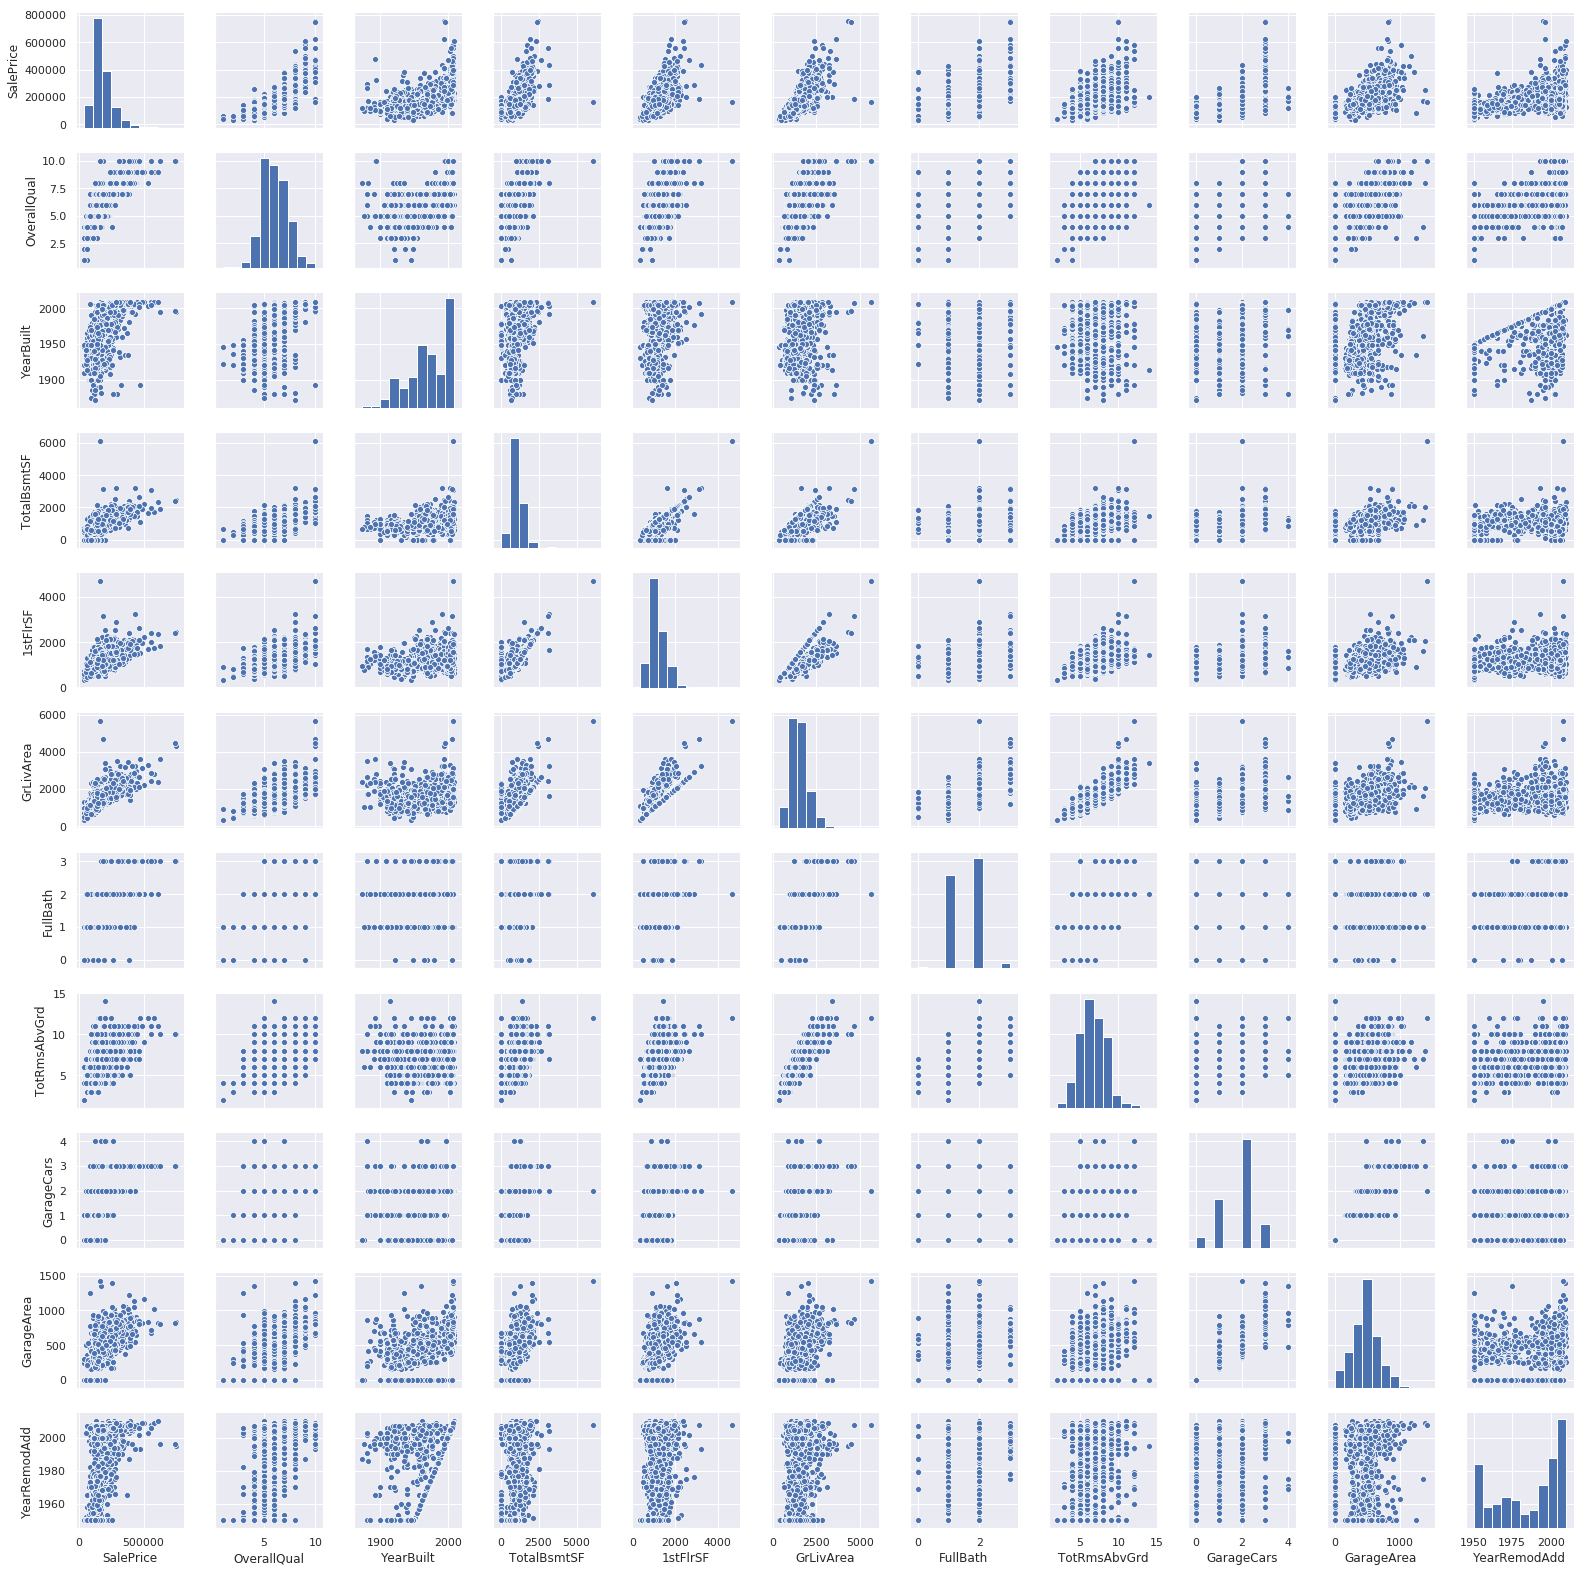

In [0]:
# Scatterplot
sns.set()
cols = ['SalePrice','OverallQual','YearBuilt','TotalBsmtSF','1stFlrSF',
        'GrLivArea','FullBath', 'TotRmsAbvGrd', 'GarageCars','GarageArea','YearRemodAdd']
sns.pairplot(train_new[cols], size=2)
plt.show();

##Visualization of top features

(-0.5, 3.5, 0, 800000)

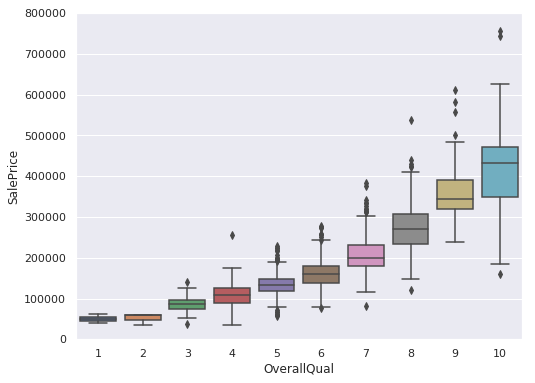

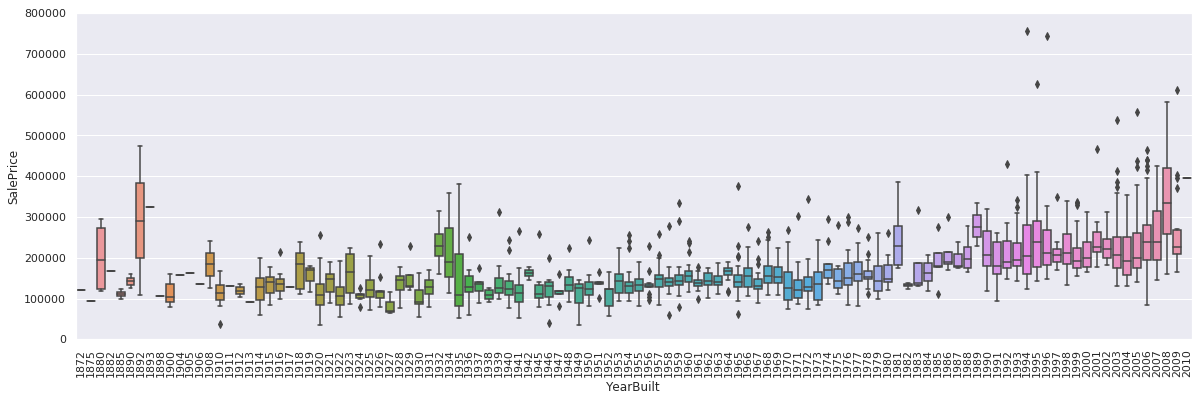

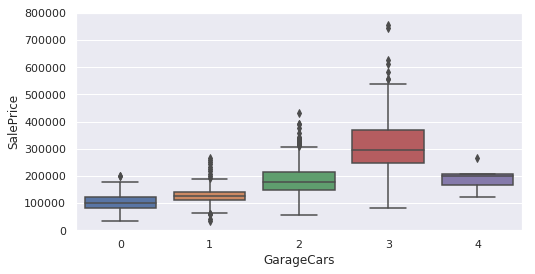

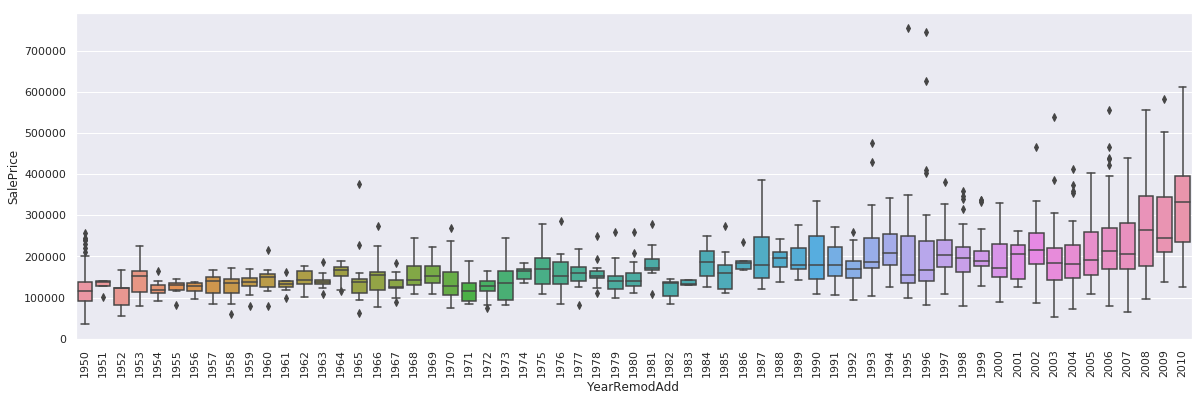

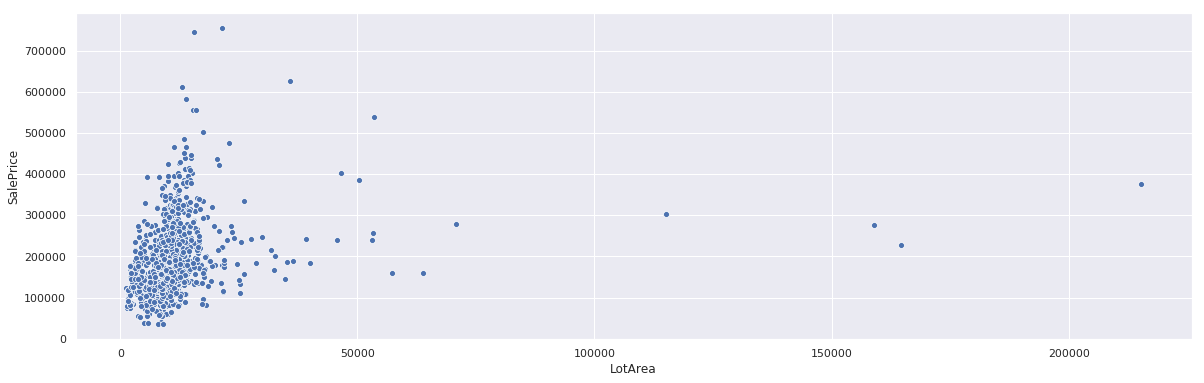

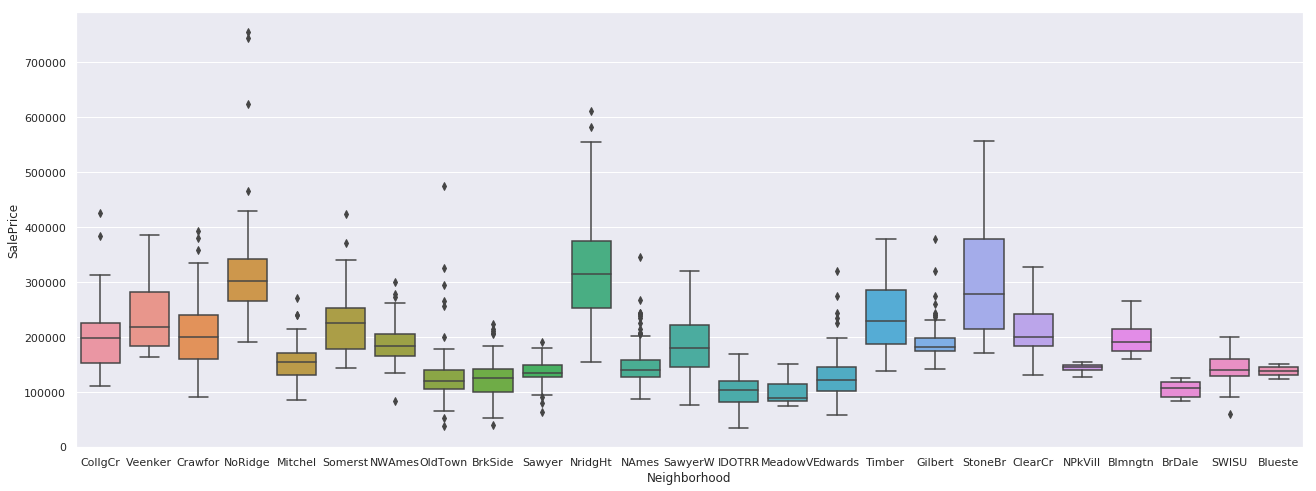

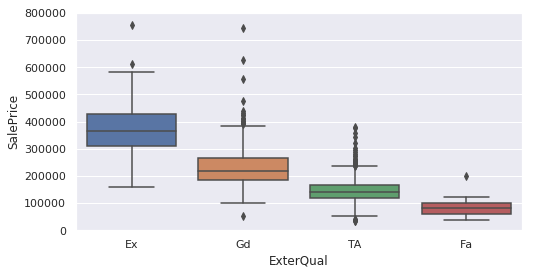

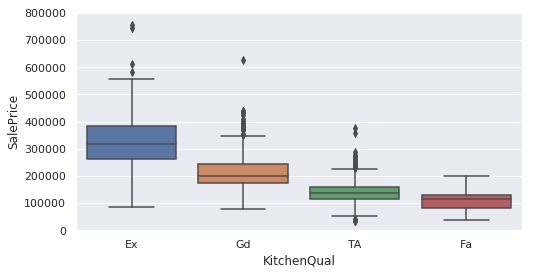

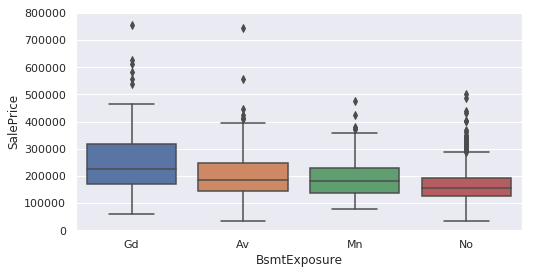

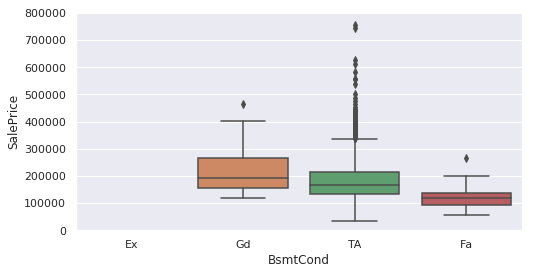

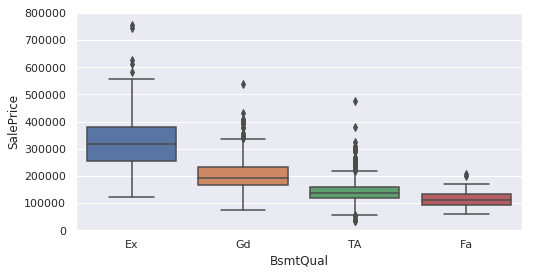

In [0]:
# Boxplot of OverallQual/SalePrice
var = 'OverallQual'
data = pd.concat([train_new['SalePrice'], train_new[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

# Boxplot of YearBuilt/SalePrice
var = 'YearBuilt'
data = pd.concat([train_new['SalePrice'], train_new[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

# Boxplot of GarageCars/SalePrice
data = pd.concat([train_new['SalePrice'], train_new['GarageCars']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='GarageCars', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


#Year Remod vs Saleprice
plt.subplots(figsize=(20, 6))
D = pd.concat([train_new['SalePrice'], train_new['YearRemodAdd']], axis=1)
BP = sns.boxplot(x='YearRemodAdd', y="SalePrice", data=D)
plt.xticks(rotation=90)

#Lot Area vs Saleprice
plt.subplots(figsize=(20, 6))
D = pd.concat([train_new['SalePrice'], train_new['LotArea']], axis=1)
BP = sns.scatterplot(x='LotArea', y="SalePrice", data=D)

#Neighborhood vs SalePrice
plt.subplots(figsize=(22, 8))
D = pd.concat([train_new['SalePrice'], train_new['Neighborhood']], axis=1)
BP = sns.boxplot(x='Neighborhood', y="SalePrice", data=D)


# Boxplot of ExterQual/SalePrice
data = pd.concat([train_new['SalePrice'], train_new['ExterQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='ExterQual', y="SalePrice", data=data,
                  order=["Ex", "Gd", "TA", "Fa"])
fig.axis(ymin=0, ymax=800000)


# Boxplot of KitchenQual/SalePrice
data = pd.concat([train_new['SalePrice'], train_new['KitchenQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='KitchenQual', y="SalePrice", data=data,
                  order=["Ex", "Gd", "TA", "Fa"])
fig.axis(ymin=0, ymax=800000)

# Boxplot of BsmtExposure/SalePrice
data = pd.concat([train_new['SalePrice'], train_new['BsmtExposure']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='BsmtExposure', y="SalePrice", data=data,
                  order=["Gd", "Av", "Mn", "No"])
fig.axis(ymin=0, ymax=800000)

# Boxplot of BsmtCond/SalePrice
data = pd.concat([train_new['SalePrice'], train_new['BsmtCond']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='BsmtCond', y="SalePrice", data=data,
                  order=["Ex", "Gd", "TA", "Fa"])
fig.axis(ymin=0, ymax=800000)

# Boxplot of BsmtQual/SalePrice
data = pd.concat([train_new['SalePrice'], train_new['BsmtQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='BsmtQual', y="SalePrice", data=data, order=["Ex", "Gd", "TA", "Fa"])
fig.axis(ymin=0, ymax=800000)

# Boxplot of Neighborhood/SalePrice



# Feature Engineering
  - Feature selection
  - Missing data processing
  - Normalization Transformation: log operator and etc
  - One hot encoding for categorical features
  
  

## One hot encoding for categorical features

In [0]:

        

## This converts categorical feature to one-hot-encoded feature
def oneHotEncode(df,colNames):
    for col in colNames:
      
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)            
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

  
  
#print('There were {} columns before encoding categorical features for training data'.format(train_new.shape[1]))
#train_encoded = oneHotEncode(train_new, category_columns_new)
#print('There are {} columns after encoding categorical features for training data'.format(train_encoded.shape[1]))


#print('There were {} columns before encoding categorical features for test data'.format(test_new.shape[1]))
#test_encoded = oneHotEncode(test_new, category_columns_new)
#print('There are {} columns after encoding categorical features for test data'.format(test_encoded.shape[1]))




# Modeling
  - linear regression, 
  - random forest
  - DNN
    
  - regularization: L1, L2




### Scaling features

In [0]:
# Extract and keep the SalePrice (target) column
Y_train_all = train['SalePrice']
# Drop SalePrice: Train and Test have same dimension.
train_new.drop('SalePrice', axis=1, inplace=True)

# Preseve test dataset IDs. We will need them for final prediction/submission
test_id = test.iloc[:,0]

# Combine test and train
combined_df = pd.concat([train_new, test_new]).reset_index()
combined_df.shape

print(combined_df.head())

   index  1stFlrSF  2ndFlrSF  ...  YearBuilt  YearRemodAdd YrSold
0      0       856       854  ...       2003          2003   2008
1      1      1262         0  ...       1976          1976   2007
2      2       920       866  ...       2001          2002   2008
3      3       961       756  ...       1915          1970   2006
4      4      1145      1053  ...       2000          2000   2008

[5 rows x 76 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


### Basic feature engineering


### Remove Non-significant Columns

In [0]:

# ID is not useful

# PoolQC','MiscFeature','Alley','Fence','FireplaceQu
# Almost all rows have same value for Utilities, making this variable not useful
combined_df.drop('Utilities', axis=1, inplace=True)
combined_df.drop('Street', axis=1, inplace=True)
combined_df.drop('MiscVal', axis=1, inplace=True)
combined_df.drop('GarageCars', axis=1, inplace=True)
combined_df.drop('TotRmsAbvGrd', axis=1, inplace=True)
combined_df.drop('TotalBsmtSF', axis=1, inplace=True)

### replace missing values or nan with 0

In [0]:
# remove features that have more than 15% of missing values in train and test
#train_new= train_data.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'] ,axis=1)
#test_new= test_data.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'] ,axis=1)



combined_df['MSZoning'].fillna(combined_df['MSZoning'].mode()[0], inplace=True)
combined_df['Functional'].fillna(combined_df['Functional'].mode()[0], inplace=True)
combined_df['SaleType'].fillna(combined_df['SaleType'].mode()[0], inplace=True)
combined_df['KitchenQual'].fillna(combined_df['KitchenQual'].mode()[0], inplace=True)
combined_df['Exterior1st'].fillna(combined_df['Exterior1st'].mode()[0], inplace=True)
combined_df['Exterior2nd'].fillna(combined_df['Exterior2nd'].mode()[0], inplace=True)



default_none_columns = ['GarageType', 'GarageFinish', 'GarageQual',
                        'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                        'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']

for none_column in default_none_columns:
    combined_df[none_column].fillna('None', inplace=True)
    
    
    
default_zero_columns = ['GarageYrBlt','GarageArea','BsmtFinSF1','BsmtFinSF2',
                        'BsmtUnfSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']

for zero_column in default_zero_columns:
    combined_df[zero_column].fillna(0, inplace=True)
    
    
    
combined_df['Electrical'].fillna(combined_df['Electrical'].mode()[0], inplace=True)


combined_df['LotFrontage'].fillna(combined_df['LotFrontage'].mean(), inplace=True)



### apply log to Y


In [0]:
Y_train_all = np.log(Y_train_all)

In [0]:

category_columns = [f for f in combined_df.columns if combined_df.dtypes[f] == 'object']

print(category_columns)

combined_df = oneHotEncode(combined_df, category_columns)

['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType']


In [0]:
X_train_all = combined_df[:train.shape[0]]
X_test = combined_df[train.shape[0]:]
X_train_all.shape,X_test.shape

((1460, 274), (1459, 274))

In [0]:
print(X_train_all.head(5))

scaler = StandardScaler()
scaler.fit(X_train_all)

X_train_all = scaler.transform(X_train_all)
X_train_all = pd.DataFrame(X_train_all, columns = combined_df.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = combined_df.columns)

   index  1stFlrSF  2ndFlrSF  ...  SaleType_New  SaleType_Oth  SaleType_WD
0      0       856       854  ...             0             0            1
1      1      1262         0  ...             0             0            1
2      2       920       866  ...             0             0            1
3      3       961       756  ...             0             0            1
4      4      1145      1053  ...             0             0            1

[5 rows x 274 columns]


###Split Back into Train and Test


In [0]:
X_train_all = combined_df[:train.shape[0]]
X_test = combined_df[train.shape[0]:]
X_train_all.shape,X_test.shape

((1460, 274), (1459, 274))

### Linear model
OLS model, Ridge Regression, Least Absolute Shrinkage and Selection Operator (LASSO), 

### Create Cross Validation (Dev) Data Set for Testing Model Performance

In [0]:
# Define cutoff to bisect train and cross validation data
cutoff = (len(train) * 80) // 100

X_dev = X_train_all[cutoff:]
Y_dev = Y_train_all[cutoff:]
X_train = X_train_all[:cutoff]
Y_train = Y_train_all[:cutoff]
X_dev.shape,Y_dev.shape

((292, 274), (292,))

In [0]:
def rmse(predictions, targets):
    return '%.4f' % np.sqrt(mean_squared_error(predictions,targets))
  
res = defaultdict(dict)

def benchmark(model, name=None):
    '''
    Run the given model and store benchmarks for later analysis.
    '''
    if not name:
        name = model.__class__.__name__
    t0 = time.clock()
    model.fit(X_train, Y_train)
    res[name]['train_time'] = time.clock() - t0
    res[name]['train_rmse'] = rmse(Y_train, model.predict(X_train))
    
    t0 = time.clock()
    Y_pred = model.predict(X_dev)
    res[name]['test_time'] = time.clock() - t0
    res[name]['test_rmse'] = rmse(Y_dev, Y_pred)
    return model

## Model Baseline

In [0]:
# Running all models with default values
benchmark(LinearRegression())
benchmark(Lasso(alpha=1.0))
benchmark(Ridge(alpha=1.0))
benchmark(ElasticNet(alpha=1.0))
est = benchmark(GradientBoostingRegressor(learning_rate=0.1, n_estimators=100))
benchmark(RandomForestRegressor(n_estimators=10, max_depth=None))
res_df = pd.DataFrame(data=res).T
res_df[['train_time','test_time','train_rmse','test_rmse']]

,train_time,test_time,train_rmse,test_rmse
LinearRegression,0.069787,0.003022,0.0947,346.7705
Lasso,0.057009,0.004167,0.1742,0.2600
Ridge,0.022923,0.002953,0.0963,0.1876
ElasticNet,0.087635,0.002956,0.1661,0.2528
GradientBoostingRegressor,0.980529,0.002594,0.0781,0.1305
RandomForestRegressor,0.274308,0.002732,0.0657,0.1537


## Using Grid Search to Tune Hyperparameters

In [0]:
# Ridge regression
ALPHAS = np.array([10, 5, 0.1, 0.01, 0.001, 0.0001, 0])

# Create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, cv=10, param_grid=dict(alpha=ALPHAS), scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, Y_train)

# Print best params and score
print('Best parameters:', grid.best_estimator_.alpha)
print('Best score:', -grid.best_score_)

Best parameters: 10.0
Best score: 0.01612547234541825


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
# Lasso regression
ALPHAS = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05]

# Create and fit a Lasso regression model, testing each alpha
ls = Lasso()
grid_ls = GridSearchCV(estimator=ls, param_grid=dict(alpha=ALPHAS), scoring='neg_mean_squared_error', n_jobs=-1)
grid_ls.fit(X_train, Y_train)

# Print best params and score
print('Best parameters:', grid_ls.best_estimator_.alpha)
print('Best score:', -grid_ls.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters: 0.001
Best score: 0.01684963670662926


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2899203027045818, tolerance: 0.018810859187734494
  positive)


## Test result with lasso

In [0]:
from google.colab import files

assert combined_df.isnull().sum().sum() == 0


final_model = Lasso(alpha=grid_ls.best_estimator_.alpha)
final_model.fit(X_train_all, Y_train_all)
y_test = np.exp(final_model.predict(X_test))

pred_df = pd.DataFrame()

pred_df['Id'] = test_id
pred_df['SalePrice'] = y_test
pred_df.to_csv('w207_mlairev5_Lasso.csv', index=False)
files.download('w207_mlairev5_Lasso.csv')
#print('result csv generated.')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09836671836577082, tolerance: 0.023280065898865117
  positive)


## Result submission#


In [0]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':test_orig.Id,'SalePrice':prediction})
  print(my_submission)
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

In [0]:
make_submission(predictions[:,0],'submission(NN).csv')

NameError: ignored


# Summarize the key findings. 



